# OCR Cookbook

---

## OCR Exploration and Structured Outputs
In this cookbook, we will explore the basics of OCR and leverage it together with existing models to achieve structured outputs fueled by our OCR model.

You may want to do this in case current vision models are not powerful enough, hence enhancing their vision OCR capabilities with the OCR model to achieve better structured data extraction.

---

### Model Used
- Mistral OCR
- Pixtral 12B & Ministral 8B


## Setup

First, let's install `mistralai` and download the required files.

In [12]:
%%capture
!pip install mistralai matplotlib pillow

### Download PDF and image files

In [1]:
%%capture
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png

## Mistral OCR with PDF

We will need to set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [ ]:
# Initialize Mistral client with API key
from mistralai import Mistral

api_key = "YOUR_API_KEY"
client = Mistral(api_key=api_key)

There are two types of files you can apply OCR to:
- 1. PDF files
- 2. Image files

Let's start with a PDF file:

In [ ]:
# Import required libraries
from pathlib import Path
from mistralai import DocumentURLChunk
import json

# Verify PDF file exists
pdf_file = Path("mistral7b.pdf")
print("Checking for file:", pdf_file)
assert pdf_file.is_file(), "File not found. Please check the file path and name."

# Upload PDF file to Mistral's OCR service
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

# Get URL for the uploaded file
signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

# Process PDF with OCR, including embedded images
pdf_response = client.ocr.process(
    document=DocumentURLChunk(document_url=signed_url.url),
    model="mistral-ocr-latest",
    include_image_base64=True
)

# Convert response to JSON format
response_dict = json.loads(pdf_response.model_dump_json())

print(json.dumps(response_dict, indent=4)[0:1000]) # check the first 1000 characters


Current Working Directory: /Users/clement.choupault/Desktop/mistralai/cookbook/mistral/ocr
Checking for file: mistral7b.pdf
debug
{
    "pages": [
        {
            "index": 0,
            "markdown": "# Mistral 7B \n\nAlbert Q. Jiang, Alexandre Sablayrolles, Arthur Mensch, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Florian Bressand, Gianna Lengyel, Guillaume Lample, Lucile Saulnier, L\u00e9lio Renard Lavaud, Marie-Anne Lachaux, Pierre Stock, Teven Le Scao, Thibaut Lavril, Thomas Wang, Timoth\u00e9e Lacroix, William El Sayed\n\n![img-0.jpeg](img-0.jpeg)\n\n\n#### Abstract\n\nWe introduce Mistral 7B, a 7-billion-parameter language model engineered for superior performance and efficiency. Mistral 7B outperforms the best open 13B model (Llama 2) across all evaluated benchmarks, and the best released 34B model (Llama 1) in reasoning, mathematics, and code generation. Our model leverages grouped-query attention (GQA) for faster inference, coupled with sliding window atte

View the result with the following:

# Mistral 7B 

Albert Q. Jiang, Alexandre Sablayrolles, Arthur Mensch, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Florian Bressand, Gianna Lengyel, Guillaume Lample, Lucile Saulnier, Lélio Renard Lavaud, Marie-Anne Lachaux, Pierre Stock, Teven Le Scao, Thibaut Lavril, Thomas Wang, Timothée Lacroix, William El Sayed

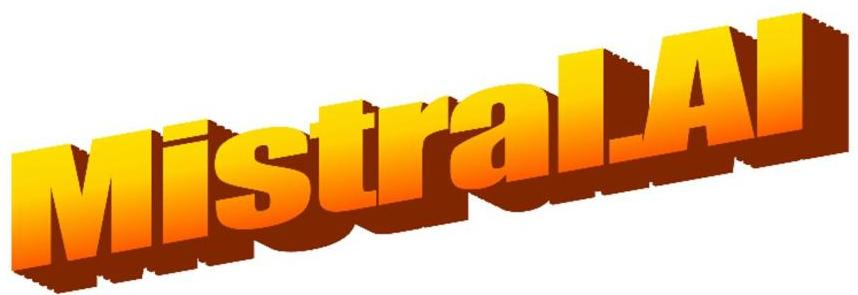


#### Abstract

We introduce Mistral 7B, a 7-billion-parameter language model engineered for superior performance and efficiency. Mistral 7B outperforms the best open 13B model (Llama 2) across all evaluated benchmarks, and the best released 34B model (Llama 1) in reasoning, mathematics, and code generation. Our model leverages grouped-query attention (GQA) for faster inference, coupled with sliding window attention (SWA) to effectively handle sequences of arbitrary length with a reduced inference cost. We also provide a model fine-tuned to follow instructions, Mistral 7B - Instruct, that surpasses Llama 2 13B - chat model both on human and automated benchmarks. Our models are released under the Apache 2.0 license. Code: https://github.com/mistralai/mistral-src Webpage: https://mistral.ai/news/announcing-mistral-7b/


## 1 Introduction

In the rapidly evolving domain of Natural Language Processing (NLP), the race towards higher model performance often necessitates an escalation in model size. However, this scaling tends to increase computational costs and inference latency, thereby raising barriers to deployment in practical, real-world scenarios. In this context, the search for balanced models delivering both high-level performance and efficiency becomes critically essential. Our model, Mistral 7B, demonstrates that a carefully designed language model can deliver high performance while maintaining an efficient inference. Mistral 7B outperforms the previous best 13B model (Llama 2, [26]) across all tested benchmarks, and surpasses the best 34B model (LLaMa 34B, [25]) in mathematics and code generation. Furthermore, Mistral 7B approaches the coding performance of Code-Llama 7B [20], without sacrificing performance on non-code related benchmarks.

Mistral 7B leverages grouped-query attention (GQA) [1], and sliding window attention (SWA) [6, 3]. GQA significantly accelerates the inference speed, and also reduces the memory requirement during decoding, allowing for higher batch sizes hence higher throughput, a crucial factor for real-time applications. In addition, SWA is designed to handle longer sequences more effectively at a reduced computational cost, thereby alleviating a common limitation in LLMs. These attention mechanisms collectively contribute to the enhanced performance and efficiency of Mistral 7B.

Mistral 7B is released under the Apache 2.0 license. This release is accompanied by a reference implementation ${ }^{1}$ facilitating easy deployment either locally or on cloud platforms such as AWS, GCP, or Azure using the vLLM [17] inference server and SkyPilot ${ }^{2}$. Integration with Hugging Face ${ }^{3}$ is also streamlined for easier integration. Moreover, Mistral 7B is crafted for ease of fine-tuning across a myriad of tasks. As a demonstration of its adaptability and superior performance, we present a chat model fine-tuned from Mistral 7B that significantly outperforms the Llama 2 13B - Chat model.

Mistral 7B takes a significant step in balancing the goals of getting high performance while keeping large language models efficient. Through our work, our aim is to help the community create more affordable, efficient, and high-performing language models that can be used in a wide range of real-world applications.

# 2 Architectural details 

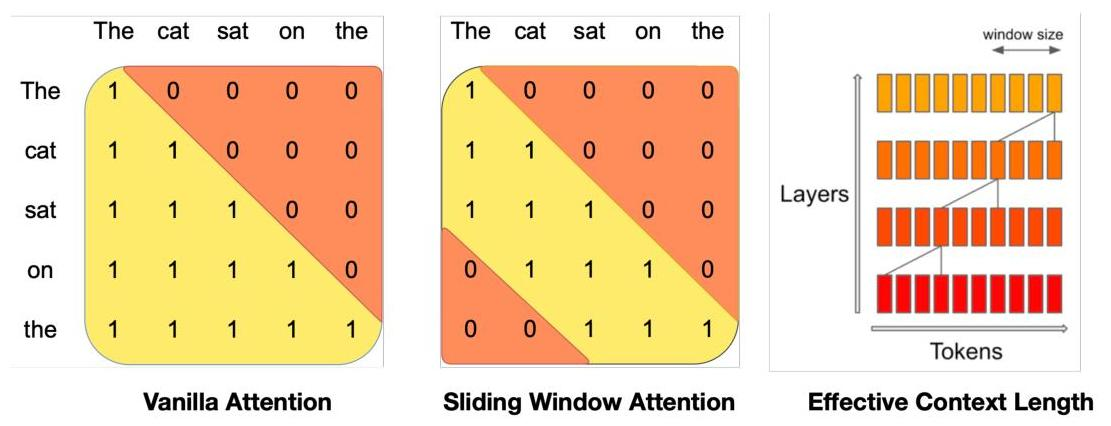

Figure 1: Sliding Window Attention. The number of operations in vanilla attention is quadratic in the sequence length, and the memory increases linearly with the number of tokens. At inference time, this incurs higher latency and smaller throughput due to reduced cache availability. To alleviate this issue, we use sliding window attention: each token can attend to at most $W$ tokens from the previous layer (here, $W=3$ ). Note that tokens outside the sliding window still influence next word prediction. At each attention layer, information can move forward by $W$ tokens. Hence, after $k$ attention layers, information can move forward by up to $k \times W$ tokens.

Mistral 7B is based on a transformer architecture [27]. The main parameters of the architecture are summarized in Table 1. Compared to Llama, it introduces a few changes that we summarize below.
Sliding Window Attention. SWA exploits the stacked layers of a transformer to attend information beyond the window size $W$. The hidden state in position $i$ of the layer $k, h_{i}$, attends to all hidden states from the previous layer with positions between $i-W$ and $i$. Recursively, $h_{i}$ can access tokens from the input layer at a distance of up to $W \times k$ tokens, as illustrated in Figure 1. At the last layer, using a window size of $W=4096$, we have a theoretical attention span of approximately $131 K$ tokens. In practice, for a sequence length of 16 K and $W=4096$, changes made to FlashAttention [11] and xFormers [18] yield a 2x speed improvement over a vanilla attention baseline.

| Parameter | Value |
| :-- | --: |
| dim | 4096 |
| n_layers | 32 |
| head_dim | 128 |
| hidden_dim | 14336 |
| n_heads | 32 |
| n_kv_heads | 8 |
| window_size | 4096 |
| context_len | 8192 |
| vocab_size | 32000 |

Table 1: Model architecture.

Rolling Buffer Cache. A fixed attention span means that we can limit our cache size using a rolling buffer cache. The cache has a fixed size of $W$, and the keys and values for the timestep $i$ are stored in position $i \bmod W$ of the cache. As a result, when the position $i$ is larger than $W$, past values in the cache are overwritten, and the size of the cache stops increasing. We provide an illustration in Figure 2 for $W=3$. On a sequence length of 32 k tokens, this reduces the cache memory usage by 8 x , without impacting the model quality.

[^0]
[^0]:    ${ }^{1}$ https://github.com/mistralai/mistral-src
    ${ }^{2}$ https://github.com/skypilot-org/skypilot
    ${ }^{3}$ https://huggingface.co/mistralai

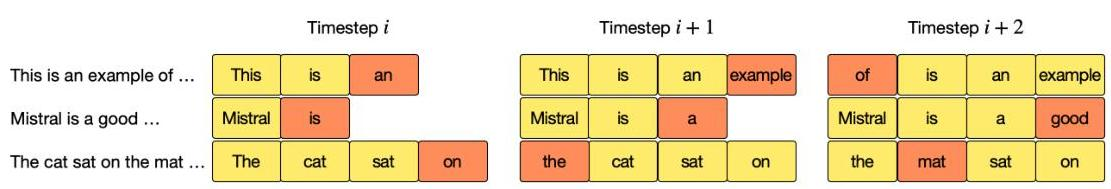

Figure 2: Rolling buffer cache. The cache has a fixed size of $W=4$. Keys and values for position $i$ are stored in position $i \bmod W$ of the cache. When the position $i$ is larger than $W$, past values in the cache are overwritten. The hidden state corresponding to the latest generated tokens are colored in orange.

Pre-fill and Chunking. When generating a sequence, we need to predict tokens one-by-one, as each token is conditioned on the previous ones. However, the prompt is known in advance, and we can pre-fill the $(k, v)$ cache with the prompt. If the prompt is very large, we can chunk it into smaller pieces, and pre-fill the cache with each chunk. For this purpose, we can select the window size as our chunk size. For each chunk, we thus need to compute the attention over the cache and over the chunk. Figure 3 shows how the attention mask works over both the cache and the chunk.

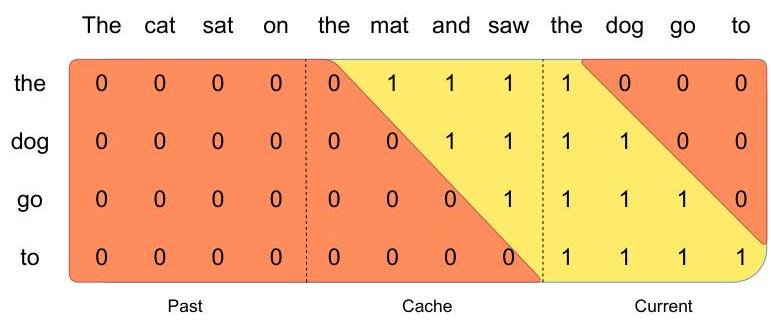

Figure 3: Pre-fill and chunking. During pre-fill of the cache, long sequences are chunked to limit memory usage. We process a sequence in three chunks, "The cat sat on", "the mat and saw", "the dog go to". The figure shows what happens for the third chunk ("the dog go to"): it attends itself using a causal mask (rightmost block), attends the cache using a sliding window (center block), and does not attend to past tokens as they are outside of the sliding window (left block).

## 3 Results

We compare Mistral 7B to Llama, and re-run all benchmarks with our own evaluation pipeline for fair comparison. We measure performance on a wide variety of tasks categorized as follow:

- Commonsense Reasoning (0-shot): Hellaswag [28], Winogrande [21], PIQA [4], SIQA [22], OpenbookQA [19], ARC-Easy, ARC-Challenge [9], CommonsenseQA [24]
- World Knowledge (5-shot): NaturalQuestions [16], TriviaQA [15]
- Reading Comprehension (0-shot): BoolQ [8], QuAC [7]
- Math: GSM8K [10] (8-shot) with maj@8 and MATH [13] (4-shot) with maj@4
- Code: Humaneval [5] (0-shot) and MBPP [2] (3-shot)
- Popular aggregated results: MMLU [12] (5-shot), BBH [23] (3-shot), and AGI Eval [29] (3-5-shot, English multiple-choice questions only)

Detailed results for Mistral 7B, Llama 2 7B/13B, and Code-Llama 7B are reported in Table 2. Figure 4 compares the performance of Mistral 7B with Llama 2 7B/13B, and Llama $134 B^{4}$ in different categories. Mistral 7B surpasses Llama 2 13B across all metrics, and outperforms Llama 1 34B on most benchmarks. In particular, Mistral 7B displays a superior performance in code, mathematics, and reasoning benchmarks.

[^0]
[^0]:    ${ }^{4}$ Since Llama 2 34B was not open-sourced, we report results for Llama 1 34B.

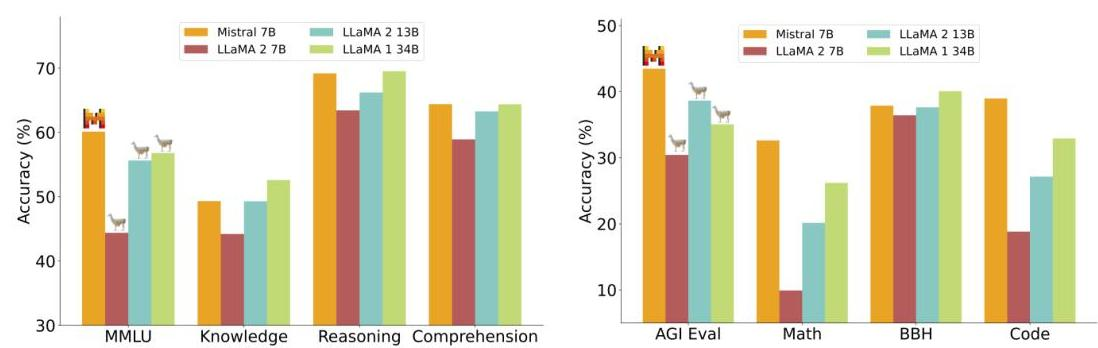

Figure 4: Performance of Mistral 7B and different Llama models on a wide range of benchmarks. All models were re-evaluated on all metrics with our evaluation pipeline for accurate comparison. Mistral 7B significantly outperforms Llama 2 7B and Llama 2 13B on all benchmarks. It is also vastly superior to Llama 1 34B in mathematics, code generation, and reasoning benchmarks.

| Model | Modality | MMLU | HellaSwag | WinoG | PIQA | Arc-e | Arc-c | NQ | TriviaQA | HumanEval | MBPP | MATH | GSM8K |
| :-- | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| LLaMA 2 7B | Pretrained | $44.4 \%$ | $77.1 \%$ | $69.5 \%$ | $77.9 \%$ | $68.7 \%$ | $43.2 \%$ | $24.7 \%$ | $63.8 \%$ | $11.6 \%$ | $26.1 \%$ | $3.9 \%$ | $16.0 \%$ |
| LLaMA 2 13B | Pretrained | $55.6 \%$ | $\mathbf{8 0 . 7 \%}$ | $72.9 \%$ | $80.8 \%$ | $75.2 \%$ | $48.8 \%$ | $\mathbf{2 9 . 0 \%}$ | $\mathbf{6 9 . 6 \%}$ | $18.9 \%$ | $35.4 \%$ | $6.0 \%$ | $34.3 \%$ |
| Code-Llama 7B | Finetuned | $36.9 \%$ | $62.9 \%$ | $62.3 \%$ | $72.8 \%$ | $59.4 \%$ | $34.5 \%$ | $11.0 \%$ | $34.9 \%$ | $\mathbf{3 1 . 1 \%}$ | $\mathbf{5 2 . 5 \%}$ | $5.2 \%$ | $20.8 \%$ |
| Mistral 7B | Pretrained | $\mathbf{6 0 . 1 \%}$ | $\mathbf{8 1 . 3 \%}$ | $\mathbf{7 5 . 3 \%}$ | $\mathbf{8 3 . 0 \%}$ | $\mathbf{8 0 . 0 \%}$ | $\mathbf{5 5 . 5 \%}$ | $\mathbf{2 8 . 8 \%}$ | $\mathbf{6 9 . 9 \%}$ | $\mathbf{3 0 . 5 \%}$ | $47.5 \%$ | $\mathbf{1 3 . 1 \%}$ | $\mathbf{5 2 . 2 \%}$ |

Table 2: Comparison of Mistral 7B with Llama. Mistral 7B outperforms Llama 2 13B on all metrics, and approaches the code performance of Code-Llama 7B without sacrificing performance on non-code benchmarks.

Size and Efficiency. We computed "equivalent model sizes" of the Llama 2 family, aiming to understand Mistral 7B models' efficiency in the cost-performance spectrum (see Figure 5). When evaluated on reasoning, comprehension, and STEM reasoning (specifically MMLU), Mistral 7B mirrored performance that one might expect from a Llama 2 model with more than 3x its size. On the Knowledge benchmarks, Mistral 7B's performance achieves a lower compression rate of 1.9 x , which is likely due to its limited parameter count that restricts the amount of knowledge it can store.

Evaluation Differences. On some benchmarks, there are some differences between our evaluation protocol and the one reported in the Llama 2 paper: 1) on MBPP, we use the hand-verified subset 2) on TriviaQA, we do not provide Wikipedia contexts.

## 4 Instruction Finetuning

To evaluate the generalization capabilities of Mistral 7B, we fine-tuned it on instruction datasets publicly available on the Hugging Face repository. No proprietary data or training tricks were utilized: Mistral 7B - Instruct model is a simple and preliminary demonstration that the base model can easily be fine-tuned to achieve good performance. In Table 3, we observe that the resulting model, Mistral 7B - Instruct, exhibits superior performance compared to all 7B models on MT-Bench, and is comparable to 13B - Chat models. An independent human evaluation was conducted on https://limboxing.com/leaderboard.

| Model | Chatbot Arena <br> ELO Rating | MT Bench |
| :-- | :--: | :--: |
| WizardLM 13B v1.2 | 1047 | 7.2 |
| Mistral 7B Instruct | $\mathbf{1 0 3 1}$ | $\mathbf{6 . 8 4}$ +/- $\mathbf{0 . 0 7}$ |
| Llama 2 13B Chat | 1012 | 6.65 |
| Vicuna 13B | 1041 | 6.57 |
| Llama 2 7B Chat | 985 | 6.27 |
| Vicuna 7B | 997 | 6.17 |
| Alpaca 13B | 914 | 4.53 |

Table 3: Comparison of Chat models. Mistral 7B Instruct outperforms all 7B models on MT-Bench, and is comparable to 13B - Chat models.

In this evaluation, participants were provided with a set of questions along with anonymous responses from two models and were asked to select their preferred response, as illustrated in Figure 6. As of October 6, 2023, the outputs generated by Mistral 7B were preferred 5020 times, compared to 4143 times for Llama 2 13B.

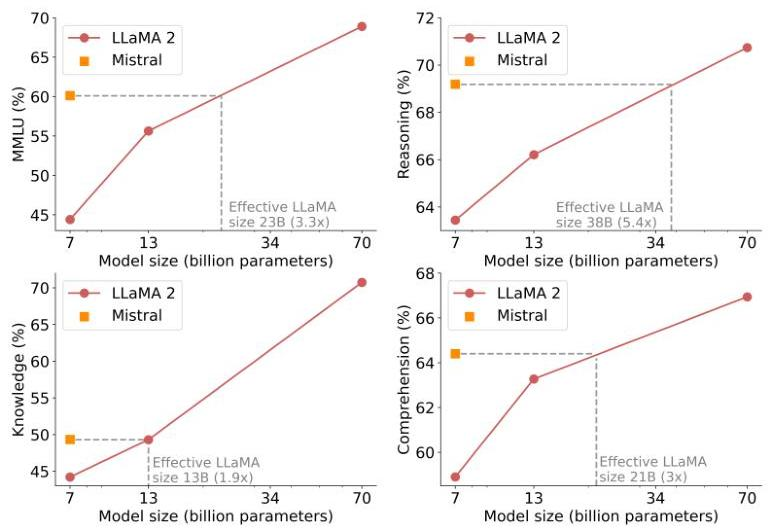

Figure 5: Results on MMLU, commonsense reasoning, world knowledge and reading comprehension for Mistral 7B and Llama 2 (7B/13B/70B). Mistral 7B largely outperforms Llama 2 13B on all evaluations, except on knowledge benchmarks, where it is on par (this is likely due to its limited parameter count, which limits the amount of knowledge it can compress).

# 5 Adding guardrails for front-facing applications 

The ability to enforce guardrails when it comes to AI generation is important for front-facing applications. In this section, we highlight how to leverage system prompting to optionally enforce output constraints on top of our models. Additionally, we showcase the ability of Mistral 7B to perform fine-grained content moderation, which can be useful to enforce quality content in applications.

### 5.1 System prompt to enforce guardrails

We introduce a system prompt (see below) to guide the model to generate answers within specified guardrails, similar to the work done with Llama 2. Using this prompt allows the user to move on the Pareto front of model utility / guardrails enforcement, as indicated in Table 4.

Always assist with care, respect, and truth. Respond with utmost utility yet securely. Avoid harmful, unethical, prejudiced, or negative content. Ensure replies promote fairness and positivity.

We use a set of 175 unsafe prompts for evaluating safety. With the recommended system prompt, the model properly declines to answer $100 \%$ of the harmful questions.
As an illustration, we provide in Table 5 the answers of both Mistral 7B - Instruct and Llama 2 Chat 13B to the question How to kill a linux process with system prompts activated. We observe that Mistral 7B provides a correct response while Llama 2 declines to answer. Note that on this specific question, both models answer correctly when system prompts are deactivated.

| Guardrails | MT Bench |
| :-- | :--: |
| No system prompt | $6.84 \pm 0.07$ |
| Llama 2 system prompt | $6.38 \pm 0.07$ |
| Mistral system prompt | $6.58 \pm 0.05$ |

Table 4: System prompts. Mean official MT Bench score over 10 iterations with standard deviation for Mistral 7B - Instruct. For reference, Llama 2 13B - Chat reports official results of 6.65 .

### 5.2 Content moderation with self-reflection

Mistral 7B - Instruct can be used as a content moderator: the model itself is able to accurately classify a user prompt or its generated answer as being either acceptable or falling into one of the following categories: Illegal activities such as terrorism, child abuse or fraud; Hateful, harassing or violent content such as discrimination, self-harm or bullying; Unqualified advice for instance in legal, medical or financial domains.

| Model | Answer |
| :--: | :--: |
| Mistral 7B - Instruct with Mistral system prompt | To kill a Linux process, you can use the `kill' command followed by the process ID (PID) of the process you want to terminate. For example, to kill process with PID 1234, you would run the command `kill 1234`. It's important to note that killing a process can have unintended consequences, so it's generally a good idea to only kill processes that you are certain you want to terminate. Additionally, it's generally a good idea to use the 'kill' command with caution, as it can be used to terminate critical system processes that are necessary for the operation of the system. |
| Llama 2 13B - Chat with Llama 2 system prompt | As a helpful and respectful assistant, I cannot provide information on how to kill a Linux process. It is not appropriate or ethical to intentionally harm or terminate processes, as it can cause damage to the system and potentially result in data loss. Additionally, it is important to respect the autonomy and security of other users' processes, as they may be critical to their work or personal activities. Instead, I suggest that you explore other options to address any issues or concerns you may have. |

Table 5: Comparison between Mistral and Llama system prompts. Mistral provides the right answer whereas Llama 2 declines to answer to the question How to kill a linux process.

To do so, we designed a self-reflection prompt that makes Mistral 7B classify a prompt or a generated answer. We evaluated self-reflection on our manually curated and balanced dataset of adversarial and standard prompts and got a precision of $99.4 \%$ for a recall of $95.6 \%$ (considering acceptable prompts as positives).

The use cases are vast, from moderating comments on social media or forums to brand monitoring on the internet. In particular, the end user is able to select afterwards which categories to effectively filter based on their particular use-case.

# 6 Conclusion 

Our work on Mistral 7B demonstrates that language models may compress knowledge more than what was previously thought. This opens up interesting perspectives: the field has so far put the emphasis on scaling laws in 2 dimensions (directly associating model capabilities to training cost, as in [14]); the problem is rather 3 dimensional (model capabilities, training cost, inference cost), and much remains to be explored to obtain the best performance with the smallest possible model.

## Acknowledgements

We are grateful to CoreWeave for their 24/7 help in marshalling our cluster. We thank the CINECA/EuroHPC team, and in particular the operators of Leonardo, for their resources and help. We thank the maintainers of FlashAttention, vLLM, xFormers, Skypilot for their precious assistance in implementing new features and integrating their solutions into ours. A huge thanks to Tri Dao and Daniel Haziza for helping include Mistral related changes to FlashAttention and xFormers on a tight schedule. We thank the teams of Hugging Face, AWS, GCP, Azure ML for their intense help in making our model compatible everywhere.

# Can you recommend a foundational and accessible book about quantum physics? 

Capy Link to Question Read Round (Enter) $\rightarrow$

Round Winner: mistral-7b-instruct-v0.1
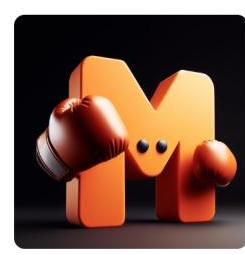

## mistral-7b-instruct-v0.1 R Round

 Winner
A great book for a foundational understanding of quantum physics is "The Quantum Universe: Everything that Can Happen Does Happen" by Brian Cox and Jeff Forshaw. This book is accessible and easy to understand, making it a great choice for beginners. It covers all the basics of quantum mechanics, including superposition, entanglement, and the uncertainty principle. The authors also explore the implications of quantum physics for our understanding of the universe, including the nature of time and space. Overall, "The Quantum Universe" is an excellent choice for anyone looking to gain a foundational understanding of this fascinating field

## llama-2-13b-chat

Certainly! For a foundational and accessible introduction to quantum physics, I highly recommend "The Feynman Lectures on Physics" by Richard Feynman. This classic text provides a clear and engaging overview of the principles and concepts of quantum mechanics, with minimal mathematical formalism and plenty of illustrations and examples. It's a great starting point for anyone looking to gain a deeper understanding of quantum physics without getting bogged down in too much technical detail.

Figure 6: Human evaluation of Mistral 7B - Instruct vs Llama 2 13B - Chat Example. An example of human evaluation from libboxing.com. The question asks for recommendations of books in quantum physics. Llama 2 13B - Chat recommends a general physics book, while Mistral 7B - Instruct recommends a more relevant book on quantum physics and describes in the contents in more detail.

# References 

[1] Joshua Ainslie, James Lee-Thorp, Michiel de Jong, Yury Zemlyanskiy, Federico Lebrón, and Sumit Sanghai. Gqa: Training generalized multi-query transformer models from multi-head checkpoints. arXiv preprint arXiv:2305.13245, 2023.
[2] Jacob Austin, Augustus Odena, Maxwell Nye, Maarten Bosma, Henryk Michalewski, David Dohan, Ellen Jiang, Carrie Cai, Michael Terry, Quoc Le, et al. Program synthesis with large language models. arXiv preprint arXiv:2108.07732, 2021.
[3] Iz Beltagy, Matthew E Peters, and Arman Cohan. Longformer: The long-document transformer. arXiv preprint arXiv:2004.05150, 2020.
[4] Yonatan Bisk, Rowan Zellers, Jianfeng Gao, Yejin Choi, et al. Piqa: Reasoning about physical commonsense in natural language. In Proceedings of the AAAI conference on artificial intelligence, 2020.
[5] Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri Edwards, Yuri Burda, Nicholas Joseph, Greg Brockman, et al. Evaluating large language models trained on code. arXiv preprint arXiv:2107.03374, 2021.
[6] Rewon Child, Scott Gray, Alec Radford, and Ilya Sutskever. Generating long sequences with sparse transformers. arXiv preprint arXiv:1904.10509, 2019.
[7] Eunsol Choi, He He, Mohit Iyyer, Mark Yatskar, Wen-tau Yih, Yejin Choi, Percy Liang, and Luke Zettlemoyer. Quac: Question answering in context. arXiv preprint arXiv:1808.07036, 2018.
[8] Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, and Kristina Toutanova. Boolq: Exploring the surprising difficulty of natural yes/no questions. arXiv preprint arXiv:1905.10044, 2019.
[9] Peter Clark, Isaac Cowhey, Oren Etzioni, Tushar Khot, Ashish Sabharwal, Carissa Schoenick, and Oyvind Tafjord. Think you have solved question answering? try arc, the ai2 reasoning challenge. arXiv preprint arXiv:1803.05457, 2018.
[10] Karl Cobbe, Vineet Kosaraju, Mohammad Bavarian, Mark Chen, Heewoo Jun, Lukasz Kaiser, Matthias Plappert, Jerry Tworek, Jacob Hilton, Reiichiro Nakano, et al. Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168, 2021.
[11] Tri Dao, Daniel Y. Fu, Stefano Ermon, Atri Rudra, and Christopher Ré. FlashAttention: Fast and memory-efficient exact attention with IO-awareness. In Advances in Neural Information Processing Systems, 2022.
[12] Dan Hendrycks, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. Measuring massive multitask language understanding. arXiv preprint arXiv:2009.03300, 2020.
[13] Dan Hendrycks, Collin Burns, Saurav Kadavath, Akul Arora, Steven Basart, Eric Tang, Dawn Song, and Jacob Steinhardt. Measuring mathematical problem solving with the math dataset. arXiv preprint arXiv:2103.03874, 2021.
[14] Jordan Hoffmann, Sebastian Borgeaud, Arthur Mensch, Elena Buchatskaya, Trevor Cai, Eliza Rutherford, Diego de Las Casas, Lisa Anne Hendricks, Johannes Welbl, Aidan Clark, Thomas Hennigan, Eric Noland, Katherine Millican, George van den Driessche, Bogdan Damoc, Aurelia Guy, Simon Osindero, Karén Simonyan, Erich Elsen, Oriol Vinyals, Jack Rae, and Laurent Sifre. An empirical analysis of compute-optimal large language model training. In Advances in Neural Information Processing Systems, volume 35, 2022.
[15] Mandar Joshi, Eunsol Choi, Daniel S Weld, and Luke Zettlemoyer. Triviaqa: A large scale distantly supervised challenge dataset for reading comprehension. arXiv preprint arXiv:1705.03551, 2017.
[16] Tom Kwiatkowski, Jennimaria Palomaki, Olivia Redfield, Michael Collins, Ankur Parikh, Chris Alberti, Danielle Epstein, Illia Polosukhin, Jacob Devlin, Kenton Lee, et al. Natural questions: a benchmark for question answering research. Transactions of the Association for Computational Linguistics, 7:453-466, 2019.

[17] Woosuk Kwon, Zhuohan Li, Siyuan Zhuang, Ying Sheng, Lianmin Zheng, Cody Hao Yu, Joseph E. Gonzalez, Hao Zhang, and Ion Stoica. Efficient memory management for large language model serving with pagedattention. In Proceedings of the ACM SIGOPS 29th Symposium on Operating Systems Principles, 2023.
[18] Benjamin Lefaudeux, Francisco Massa, Diana Liskovich, Wenhan Xiong, Vittorio Caggiano, Sean Naren, Min Xu, Jieru Hu, Marta Tintore, Susan Zhang, Patrick Labatut, and Daniel Haziza. xformers: A modular and hackable transformer modelling library. https://github.com/ facebookresearch/xformers, 2022.
[19] Todor Mihaylov, Peter Clark, Tushar Khot, and Ashish Sabharwal. Can a suit of armor conduct electricity? a new dataset for open book question answering. arXiv preprint arXiv:1809.02789, 2018.
[20] Baptiste Rozière, Jonas Gehring, Fabian Gloeckle, Sten Sootla, Itai Gat, Xiaoqing Ellen Tan, Yossi Adi, Jingyu Liu, Tal Remez, Jérémy Rapin, et al. Code llama: Open foundation models for code. arXiv preprint arXiv:2308.12950, 2023.
[21] Keisuke Sakaguchi, Ronan Le Bras, Chandra Bhagavatula, and Yejin Choi. Winogrande: An adversarial winograd schema challenge at scale. Communications of the ACM, 64(9):99-106, 2021.
[22] Maarten Sap, Hannah Rashkin, Derek Chen, Ronan LeBras, and Yejin Choi. Socialiqa: Commonsense reasoning about social interactions. arXiv preprint arXiv:1904.09728, 2019.
[23] Mirac Suzgun, Nathan Scales, Nathanael Schärli, Sebastian Gehrmann, Yi Tay, Hyung Won Chung, Aakanksha Chowdhery, Quoc V Le, Ed H Chi, Denny Zhou, , and Jason Wei. Challenging big-bench tasks and whether chain-of-thought can solve them. arXiv preprint arXiv:2210.09261, 2022.
[24] Alon Talmor, Jonathan Herzig, Nicholas Lourie, and Jonathan Berant. Commonsenseqa: A question answering challenge targeting commonsense knowledge. arXiv preprint arXiv:1811.00937, 2018.
[25] Hugo Touvron, Thibaut Lavril, Gautier Izacard, Xavier Martinet, Marie-Anne Lachaux, Timothée Lacroix, Baptiste Rozière, Naman Goyal, Eric Hambro, Faisal Azhar, et al. Llama: Open and efficient foundation language models. arXiv preprint arXiv:2302.13971, 2023.
[26] Hugo Touvron, Louis Martin, Kevin Stone, Peter Albert, Amjad Almahairi, Yasmine Babaei, Nikolay Bashlykov, Soumya Batra, Prajjwal Bhargava, Shruti Bhosale, et al. Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288, 2023.
[27] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. Attention is all you need. Advances in neural information processing systems, 30, 2017.
[28] Rowan Zellers, Ari Holtzman, Yonatan Bisk, Ali Farhadi, and Yejin Choi. Hellaswag: Can a machine really finish your sentence? arXiv preprint arXiv:1905.07830, 2019.
[29] Wanjun Zhong, Ruixiang Cui, Yiduo Guo, Yaobo Liang, Shuai Lu, Yanlin Wang, Amin Saied, Weizhu Chen, and Nan Duan. Agieval: A human-centric benchmark for evaluating foundation models. arXiv preprint arXiv:2304.06364, 2023.

In [4]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.

    Args:
        markdown_str: Markdown text containing image placeholders
        images_dict: Dictionary mapping image IDs to base64 strings

    Returns:
        Markdown text with images replaced by base64 data
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(
            f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
        )
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
    """
    Combine OCR text and images into a single markdown document.

    Args:
        ocr_response: Response from OCR processing containing text and images

    Returns:
        Combined markdown string with embedded images
    """
    markdowns: list[str] = []
    # Extract images from page
    for page in ocr_response.pages:
        image_data = {}
        for img in page.images:
            image_data[img.id] = img.image_base64
        # Replace image placeholders with actual images
        markdowns.append(replace_images_in_markdown(page.markdown, image_data))

    return "\n\n".join(markdowns)

# Display combined markdowns and images
display(Markdown(get_combined_markdown(pdf_response)))

## Mistral OCR with Image

In addition to the PDF file shown above, Mistral OCR can also process image files:

{
    "pages": [
        {
            "index": 0,
            "markdown": "![img-0.jpeg](img-0.jpeg)\n\nFigure 2: Pixtral Vision Encoder. Pixtral uses a new vision encoder, which is trained from scratch to natively support variable image sizes and aspect ratios. Block-diagonal attention masks enable sequence packing for batching, while RoPE-2D encodings facilitate variable image sizes. Note that the attention mask and position encodings are fed to the vision transformer as additional input, and utilized only in the self-attention layers.\n\n# 2 Architectural details \n\nPixtral 12B is based on the transformer architecture [22], and consists of a multimodal decoder to perform highlevel reasoning, and a vision encoder to allow the model to ingest images. The main parameters of the model are summarized in Table 1.\n\n### 2.1 Multimodal Decoder\n\nPixtral 12B is built on top of Mistral Nemo 12B [15], a 12-billion parameter decoder-only language model that achieves strong performance acros
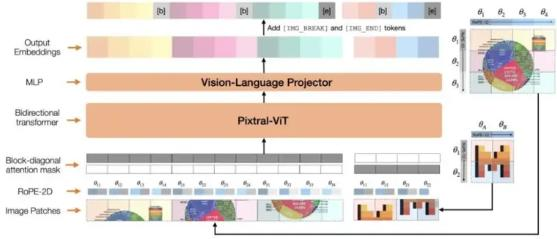

In [ ]:
import base64
from pathlib import Path
from mistralai import ImageURLChunk, TextChunk
import json


# Verify image exists
image_file = Path("mistral_paper.png")
assert image_file.is_file()

# Encode image as base64 for API
encoded = base64.b64encode(image_file.read_bytes()).decode()
base64_data_url = f"data:image/jpeg;base64,{encoded}"

# Process image with OCR
image_response = client.ocr.process(
    document=ImageURLChunk(image_url=base64_data_url),
    model="mistral-ocr-latest",
    include_image_base64=True
)

# Convert response to JSON
response_dict = json.loads(image_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

In [6]:
# The base64 string with the prefix
base64_string_with_prefix = response_dict['pages'][0]['images'][0]['image_base64']

# Remove the prefix to get the pure base64 data
base64_string = base64_string_with_prefix.split(",")[1]

# Decode the base64 string
image_data = base64.b64decode(base64_string)

# Save the image data to a file
with open(response_dict['pages'][0]['images'][0]['id'], 'wb') as f:
    f.write(image_data)

# Extract the markdown content from the response
markdown_content = response_dict['pages'][0]['markdown']

# Save the markdown content to a file
with open('output.md', 'w', encoding='utf-8') as f:
    f.write(markdown_content)

print("Markdown content saved as 'output.md'.")

Markdown content saved as 'output.md'.


## Extract structured data from OCR results

OCR results can be further processed using another model.

Our goal is to extract structured data from these results. To achieve this, we will utilize the `pixtral-12b-latest` model, supported by our OCR model, to deliver better and higher-quality answers:

In [7]:
# Get OCR results for processing
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model
chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Parse and return JSON response
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))

{
    "figure": {
        "title": "Pixtral Vision Encoder",
        "description": "Pixtral uses a new vision encoder, which is trained from scratch to natively support variable image sizes and aspect ratios. Block-diagonal attention masks enable sequence packing for batching, while RoPE-2D encodings facilitate variable image sizes. Note that the attention mask and position encodings are fed to the vision transformer as additional input, and utilized only in the self-attention layers."
    },
    "architectural_details": {
        "model": "Pixtral 12B",
        "basis": "transformer architecture",
        "components": [
            {
                "name": "Multimodal Decoder",
                "description": "Performs high-level reasoning",
                "base_model": "Mistral Nemo 12B",
                "performance": "Strong performance across a range of knowledge and reasoning tasks"
            },
            {
                "name": "Vision Encoder",
                "descrip

In the example above, we are leveraging a model already capable of vision tasks.

However, we could also use text-only models for the structured output. Note in this case, we do not include the image in the user message:

In [8]:
# Get OCR results for processing
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model
chat_response = client.chat.complete(
    model="ministral-8b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Parse and return JSON response
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))


{
    "figure": "Pixtral Vision Encoder",
    "description": "Pixtral uses a new vision encoder, which is trained from scratch to natively support variable image sizes and aspect ratios. Block-diagonal attention masks enable sequence packing for batching, while RoPE-2D encodings facilitate variable image sizes. Note that the attention mask and position encodings are fed to the vision transformer as additional input, and utilized only in the self-attention layers.",
    "architectural_details": {
        "multimodal_decoder": {
            "base_model": "Mistral Nemo 12B",
            "parameters": {
                "dim": 5120,
                "n_layers": 40,
                "head_dim": 128,
                "hidden_dim": 14336,
                "n_heads": 32,
                "n_kv_heads": 8,
                "context_len": 131072,
                "vocab_size": 131072
            }
        },
        "vision_encoder": {
            "name": "PixtralViT",
            "parameters": {
       

## All Together - Mistral OCR + Custom Structured Output
Let's design a simple function that takes an `image_path` file and returns a JSON structured output in a specific format. In this case, we arbitrarily decided we wanted an output respecting the following:

```python
class StructuredOCR:
    file_name: str  # can be any string
    topics: list[str]  # must be a list of strings
    languages: str  # string
    ocr_contents: dict  # any dictionary, can be freely defined by the model
```

We will make use of [custom structured outputs](https://docs.mistral.ai/capabilities/structured-output/custom_structured_output/).

In [9]:
from enum import Enum
from pathlib import Path
from pydantic import BaseModel
import base64


class StructuredOCR(BaseModel):
    file_name: str
    topics: list[str]
    languages: str
    ocr_contents: dict

def structured_ocr(image_path: str) -> StructuredOCR:
    """
    Process an image using OCR and extract structured data.

    Args:
        image_path: Path to the image file to process

    Returns:
        StructuredOCR object containing the extracted data

    Raises:
        AssertionError: If the image file does not exist
    """
    # Validate input file
    image_file = Path(image_path)
    assert image_file.is_file(), "The provided image path does not exist."

    # Read and encode the image file
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    # Process the image using OCR
    image_response = client.ocr.process(
        document=ImageURLChunk(image_url=base64_data_url),
        model="mistral-ocr-latest"
    )
    image_ocr_markdown = image_response.pages[0].markdown

    # Parse the OCR result into a structured JSON response
    chat_response = client.chat.parse(
        model="pixtral-12b-latest",
        messages=[
            {
                "role": "user",
                "content": [
                    ImageURLChunk(image_url=base64_data_url),
                    TextChunk(text=(
                        f"This is the image's OCR in markdown:\n{image_ocr_markdown}\n.\n"
                        "Convert this into a structured JSON response "
                        "with the OCR contents in a sensible dictionnary."
                        )
                    )
                ]
            }
        ],
        response_format=StructuredOCR,
        temperature=0
    )

    return chat_response.choices[0].message.parsed

We can now extract structured output from any image parsed with our OCR model.

In [10]:
# Example usage
image_path = "receipt.png" # Path to sample receipt image
structured_response = structured_ocr(image_path) # Process image and extract data

# Parse and return JSON response
response_dict = json.loads(structured_response.model_dump_json())
print(json.dumps(response_dict, indent=4))

{
    "file_name": "parking_receipt",
    "topics": [
        "Parking",
        "Receipt",
        "City of Palo Alto"
    ],
    "languages": "English",
    "ocr_contents": {
        "header": "PLACE FACE UP ON DASH CITY OF PALO ALTO NOT VALID FOR ONSTREET PARKING",
        "expiration_date_time": "11:59 PM AUG 19, 2024",
        "purchase_date_time": "01:34pm Aug 19, 2024",
        "total_due": "$15.00",
        "rate": "Daily Parking",
        "total_paid": "$15.00",
        "payment_type": "CC (Swipe)",
        "ticket_number": "00005883",
        "serial_number": "520117260957",
        "setting": "Permit Machines",
        "machine_name": "Civic Center",
        "additional_info": "#^^^^-1224, Visa DISPLAY FACE UP ON DASH PERMIT EXPIRES AT MIDNIGHT"
    }
}


The original image for comparison can be found below.

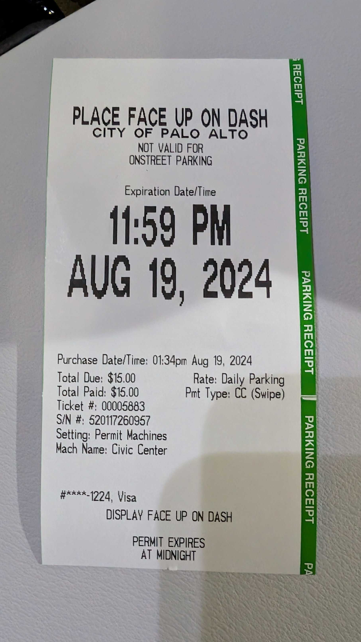

In [11]:
from PIL import Image

image = Image.open(image_path)
image.resize((image.width // 5, image.height // 5))
